# Projection of political actors onto distributive and value-based ideological axes

In [1]:
# Make sure politician2vec is up to date
#%pip uninstall politician2vec -y
#%pip install git+ssh://git@github.com/mathiasbruun/politician2vec.git

# Make sure to auto-reload politician2vec in case there are remote changes
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
from politician2vec import Politician2Vec
from politician2vec.utils import *
import pickle
import pandas as pd
import numpy as np
# import multiprocessing
# available_workers = multiprocessing.cpu_count()
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from mpl_toolkits import mplot3d
# from mpl_toolkits.mplot3d import Axes3D
import umap
import umap.plot
from bokeh.models import Label, LabelSet, ColumnDataSource
umap.plot.output_notebook(hide_banner=True)
from adjustText import adjust_text

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Data

In [117]:
# Specify path to preprocessed dataset
test_data_path = 'data/clean/preprocessed_docs_2015_high.p'

parl_data = pd.read_pickle(test_data_path).query("party not in ['SIU', 'NQ', 'JF', 'SP', 'M', 'DD', 'UFG', 'KD']")
parl_data.shape

(155150, 7)

In [118]:
grouped_docs = parl_data.groupby(['full_name', 'party'])['doc'].apply('. '.join).reset_index()
docs = [doc for doc in grouped_docs.doc]
parties = np.array([party for party in grouped_docs.party])


In [119]:
# Load embedding
model_path = 'embedding_models/fastlearn_2015_high.txt'
pol2vec_model, doc2vec_model = load_politician2vec_from_txt(model_path)

Loading Politician2Vec model...
Retrieving document embedding...
All done!


In [120]:
party_labels = {
   0: 'Socialdemokratiet',
   1: 'Venstre',
   2: 'Dansk_Folkeparti',
   3: 'Enhedslisten',
   4: 'Radikale Venstre',
   5: 'Konservative',
   6: 'SF',
   7: 'Liberal_Alliance',
   #8: 'UFG',
   8: 'Alternativet',
   #9: 'Danmarksdemokraterne',
   9: 'Nye Borgerlige',
   10: 'Frie Grønne',
   #13: 'Moderaterne',
   #14: 'Kristendemokraterne'
}

In [121]:
colormap = { # TODO: COLLECT EVERYTHING IN ONE DICT/FRAME
    'S': '#C8042C',
    'V': '#1A4289',
    'DF': '#265BA4',
    'EL': '#BF2850',
    'SF': '#B42D27',
    'KF': '#24573E',
    'RV': '#D82E8A',
    'LA': '#E7B657',
    'ALT': '#75FB4C',
    'NB': '#1E4B57',
    #'KD': '#566197',
    'FG': '#E4F04E',
    #'DD': '#3470BC',
    #'M': '#7A308B',
    #'SIU': 'lightgrey',
    #'UFG': 'lightgrey'
}

In [122]:
grouped_docs['party'].value_counts()

S      55
V      47
DF     37
EL     18
SF     16
RV     15
KF     15
LA     13
ALT    11
NB      4
FG      3
Name: party, dtype: int64

In [123]:
#map party_labels keys to party_df
party_df = grouped_docs['party'].map(party_labels)

In [124]:
party_df = get_doc_party_df(
    pol2vec_model,
    no_substantive_parties = 19,
    snippets = True
)

party_df['party'] = parties
party_df['color'] = party_df['party'].map(colormap)
cmap = party_df[['snippet', 'color']].set_index('snippet').to_dict()
party_df['full_name'] = grouped_docs['full_name']

party_df['rank'] = party_df['party'].map(party_df['party'].value_counts())
party_df.loc[party_df['party'] == 'KF', 'rank'] = 16 # necessary due to slight inconsistency in the order in which parties are output...

party_labels = party_df.drop_duplicates(keep = 'first', subset = 'party').sort_values(by='rank', ascending=False)

partyvecs = pol2vec_model.party_vectors
partylabels = pd.DataFrame(party_labels['party'])

party_labels

party sizes before filtering (party 19 is "Other"):

[[ 0 54]
 [ 1 46]
 [ 2 38]
 [ 3 18]
 [ 4 16]
 [ 5 16]
 [ 6 15]
 [ 7 13]
 [ 8 11]
 [ 9  4]
 [10  3]]


,doc,party,snippet,color,full_name,rank
2,2,S,først og fremmest vil jeg sige tillykke med va...,#C8042C,Anders Kronborg,55
6,6,V,nu har vi jo talt rigtig meget om klima som og...,#1A4289,Anne Honoré Østergaard,47
0,0,DF,jeg er lidt forvirret på et højere plan hvis j...,#265BA4,Alex Ahrendtsen,37
32,32,EL,jeg vil gerne spørge ordføreren om noget nu er...,#BF2850,Christian Juhl,18
9,9,SF,vi er flere her der har svære navne tak til fo...,#B42D27,Anne Valentina Berthelsen,16
17,17,KF,tak for en fin ordførertale det danske samfund...,#24573E,Birgitte Bergman,16
4,4,RV,det var også godt der kom styr på vandet derop...,#D82E8A,Andreas Steenberg,15
1,1,LA,statsministeren sagde i tirsdags at det simpel...,#E7B657,Alex Vanopslagh,13
28,28,ALT,nu sagde ordføreren i sin ordførertale – og ta...,#75FB4C,Carolina Magdalene Maier,11
113,113,NB,jeg skal prøve at inddrage i noget som han så ...,#1E4B57,Lars Boje Mathiesen,4


In [125]:
party_df['party'].value_counts()
# NOTE: The inconsistency in number/rank is caused by semantic outliers
# that the the model would have put into another party than their own!
# TODO: Check that we still compute party based on a priori party affil
# and maybe fix the output print of get_doc_party_df if it is misleading...
#
# I mean, wasn't this the entire reason that we needed to overwrite labels in the first place?
# As of xxxx, it was decided and so forth?

S      55
V      47
DF     37
EL     18
SF     16
RV     15
KF     15
LA     13
ALT    11
NB      4
FG      3
Name: party, dtype: int64

In [126]:
combined_hover = pd.concat([party_df, partylabels]).reset_index(drop=True)
combined_hover['color'] = combined_hover['color'].fillna('black')

## Construction of scales

In [127]:
# Arithmetic mean of input vectors
def mean_vec(vecs):
    return np.mean(vecs, axis=0)

# manually implement cosine similarity between two vectors,
# since phrases are not added to the internal doc2vec model...
def calc_cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# get vectors for input word
def get_vec(word):
    idx = pol2vec_model.word_indexes[word]
    vec = pol2vec_model.word_vectors[idx]
    
    return vec

# Define function that takes two words (or n-grams),
# retrieves the corresponding vectors, and returns the cosine similarity
def get_cos_sim(input_words):
    idcs = [pol2vec_model.word_indexes[word] for word in input_words]
    vec1, vec2 = [pol2vec_model.word_vectors[idx] for idx in idcs]
    
    return calc_cos_sim(vec1, vec2)

In [128]:
from itertools import combinations
from tqdm.notebook import tqdm

class Subdimension:
    def __init__(self, present_words, absent_words):
        self.words = {'present': present_words, 'absent': absent_words}
        self.vecs = {'present': [get_vec(word) for word in present_words], 'absent': [get_vec(word) for word in absent_words]}
    
    def add_words(self, words, present = True):
        '''
        Manually add extra words and their vector representations to the subdimension.

        Parameters
        ----------
        words : list
            List of words to add to the subdimension.
        present : bool, optional
            Whether the words belong to the present or absent endpoint of the subdimension, by default True
        '''
        for word in words:
            self._add_word(word, present)
    
    def remove_words(self, words, present = True):
        '''
        Manually remove words and their vector representations from the subdimension.

        Parameters
        ----------
        words : list
            List of words to add to the subdimension.
        present : bool, optional
            Whether the words belong to the present or absent endpoint of the subdimension, by default True
        '''
        for word in words:
            self._remove_word(word, present)

    # Backend/helper functions below
    def _add_word(self, word, present = True): # TODO: Make it impossible to add the same word twice...
        self.words['present' if present else 'absent'].append(word)
        self.vecs['present' if present else 'absent'].append(self.get_vec(word))

    def _remove_word(self, word, present = True):
        remove_idx = self.words['present' if present else 'absent'].index(word)
        self.words['present' if present else 'absent'].remove(word)
        del self.vecs['present' if present else 'absent'][remove_idx]

    def calc_subdim_vecs(self):
        '''
        Return the arithmetic mean of both the "present" and the "absent"
        word sets (i.e. construct the endpoints of the subdimension).
        '''
        #return Politician2Vec._l2_normalize(mean_vec(self.vecs['present'])), Politician2Vec._l2_normalize(mean_vec(self.vecs['absent']))
        return mean_vec(self.vecs['present']), mean_vec(self.vecs['absent']) # TODO: Figure out whether or not to normalise!
    
    def optimise_subdim(self, present=True, min_size=2, max_size=None, replace=True):
        '''
        Optimise the subdimension by finding the word set that maximises the average cosine similarity

        Parameters
        ----------
        present : bool, optional
            Whether to optimise the "present" or "absent" endpoint of the subdimension, by default True
        min_size : int, optional
            Minimum number of words in the word set, by default 2
        max_size : int, optional
            Maximum number of words in the word set, by default None (i.e. no limit)
        replace : bool, optional
            Whether to replace the original word set with the optimised one, by default True

        Returns
        -------
        best_group : list
            The optimised word set.
        best_labels : list
            The corresponding word labels.
        best_sim : float
            The average cosine similarity of the optimal word set.
        '''
        
        best_group, best_labels, best_sim = self.optimise_group_similarity(
            vectors=self.vecs['present' if present else 'absent'],
            labels=self.words['present' if present else 'absent'],
            min_size=min_size,
            max_size=max_size
            )
        
        if replace:
            self.words['present' if present else 'absent'] = best_labels
            self.vecs['present' if present else 'absent'] = best_group
        
        print('Best avg. cosine similarity:', best_sim)
        
        return best_group, best_labels
    
    @staticmethod
    def get_vec(word):
        '''Retrieve the vector representation of a given word from the politician2vec model.'''
        idx = pol2vec_model.word_indexes[word]
        vec = pol2vec_model.word_vectors[idx]

        return vec
    
    @staticmethod
    def mean_vec(vecs):
        return np.mean(vecs, axis=1)

    @staticmethod
    def group_cosine_similarity(vectors):
        '''
        Calculates the average cosine similarity between all pairs of vectors in a group.

        Parameters
        ----------
        vectors (list): A list of 300-dimensional word vectors.

        Returns
        -------
        float: The average cosine similarity between all pairs of vectors in the group.
       '''

        # calculate the pairwise cosine similarities
        pairwise_sims = []
        for v1, v2 in combinations(vectors, 2):
            sim = calc_cos_sim(v1,v2)
            pairwise_sims.append(sim)

        # calculate the average cosine similarity
        avg_sim = np.mean(pairwise_sims)

        return avg_sim

    def optimise_group_similarity(self, vectors, labels, min_size, max_size):
        '''
        Optimizes the average cosine similarity of a group of vectors byiteratively removing and
        including different combinations.

        Parameters
        ----------
        vectors (list): A list of 300-dimensional word vectors.
        labels (list): A list of labels for the vectors.
        min_size (int): The minimum size of the group to consider. Default is 2.
        max_size (int): The maximum size of the group to consider. Default is None (use all vectors).

        Returns
        -------
        list: The optimized group of vectors that maximizes the average cosine similarity.
        list: The labels of the vectors in the optimized group.
        float: The maximum average cosine similarity achieved by the optimized group.
        '''

        # set max_size to len(vectors) if not specified
        if max_size is None:
            max_size = len(vectors)

        # initialize the best group, labels, and similarity
        best_group = None
        best_labels = None
        best_sim = 0.0

        # iterate over all possible group sizes
        for size in tqdm(range(min_size, max_size+1)):
            
            # iterate over all possible combinations of vectors
            for group_idx in combinations(range(len(vectors)), size):
                
                # get the vectors and labels for the current group
                group = [vectors[i] for i in group_idx]
                group_labels = [labels[i] for i in group_idx]
                
                # calculate the average cosine similarity of the group
                sim = self.group_cosine_similarity(group)
                
                # update the best group, labels, and similarity if a new maximum is found
                if sim > best_sim:
                    best_group = group
                    best_labels = group_labels
                    best_sim = sim

        return best_group, best_labels, round(best_sim, ndigits=3)


In [130]:
distrib_left_words = [
    'bredeste skuldre',
    'arbejdere',
    'bekæmpe ulighed',
    'skatterabatter rigeste',
    'ramt kontanthjælpsloftet',
    'fattigdommen danmark',
    'leve værdigt',
    'svageste borgere',
    'social slagside',
    'nedslidte danskere',
    'løn arbejdsvilkår',
    'flere offentligt'
    ]

distrib_right_words = [
    'økonomisk ansvarlig',
    'betaler topskat',
    'vækst velstand',
    'spild penge',
    'omkostningseffektiv måde',
    'hæve pensionsalderen',
    'skattefinansieret velfærdssamfund',
    'passiv overførselsindkomst',
    'dansk erhvervsliv',
    'konkurrenceevne',
    'virksomheder investere',
    'øget privatisering',
    ]

value_left_words = [
    'ligestilling mangfoldighed',
    'ligebehandling',
    'racisme diskrimination',
    'klima miljø',
    'respekt menneskerettighederne',
    'demokratisk dannelse',
    'ytringsfrihed religionsfrihed',
    'afbureaukratisering',
    'liberalt demokrati',
    'menneskers muligheder',
    'automatisk statsborgerskab',
    'homoseksuelles rettigheder',
    'bæredygtighed',
    'skader integrationen'
    ]

value_right_words = [
    'danske kulturarv',
    'vores fædreland',
    'tryghed sikkerhed',
    'danske traditioner',
    'lov orden',
    'parallelsamfund',
    'kriminelle udlændinge',
    'forfejlet ikkevestlig',
    'selvfølgelig udvises',
    'stigende islamisering',
    'strengere straffe'
    ]

distrib_dimension = Subdimension(
    present_words=distrib_left_words,
    absent_words=distrib_right_words
    )

value_dimension = Subdimension(
    present_words=value_left_words,
    absent_words=value_right_words
    )

In [131]:
#pol2vec_model.model.wv.most_similar(positive = ['radikale', 'økonomi'], negative=['sf'], topn=300)

In [132]:
print(distrib_dimension.words)
print(len(distrib_dimension.vecs['present']))

{'present': ['bredeste skuldre', 'arbejdere', 'bekæmpe ulighed', 'skatterabatter rigeste', 'ramt kontanthjælpsloftet', 'fattigdommen danmark', 'leve værdigt', 'svageste borgere', 'social slagside', 'nedslidte danskere', 'løn arbejdsvilkår', 'flere offentligt'], 'absent': ['økonomisk ansvarlig', 'betaler topskat', 'vækst velstand', 'spild penge', 'omkostningseffektiv måde', 'hæve pensionsalderen', 'skattefinansieret velfærdssamfund', 'passiv overførselsindkomst', 'dansk erhvervsliv', 'konkurrenceevne', 'virksomheder investere', 'øget privatisering']}
12


In [133]:
# Present:
for subdimension in [distrib_dimension, value_dimension]:
    best_vecs, best_words = subdimension.optimise_subdim(present=True, min_size=8, max_size=10, replace=True)
    print(best_words)

# Absent:
for subdimension in [distrib_dimension, value_dimension]:
    best_vecs, best_words = subdimension.optimise_subdim(present=False, min_size=8, max_size=10, replace=True)
    print(best_words)

  0%|          | 0/3 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.599
['bredeste skuldre', 'skatterabatter rigeste', 'ramt kontanthjælpsloftet', 'fattigdommen danmark', 'leve værdigt', 'svageste borgere', 'nedslidte danskere', 'flere offentligt']


  0%|          | 0/3 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.608
['ligestilling mangfoldighed', 'racisme diskrimination', 'respekt menneskerettighederne', 'demokratisk dannelse', 'ytringsfrihed religionsfrihed', 'liberalt demokrati', 'menneskers muligheder', 'homoseksuelles rettigheder']


  0%|          | 0/3 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.596
['betaler topskat', 'vækst velstand', 'spild penge', 'omkostningseffektiv måde', 'skattefinansieret velfærdssamfund', 'passiv overførselsindkomst', 'virksomheder investere', 'øget privatisering']


  0%|          | 0/3 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.612
['danske kulturarv', 'vores fædreland', 'tryghed sikkerhed', 'danske traditioner', 'lov orden', 'kriminelle udlændinge', 'selvfølgelig udvises', 'strengere straffe']


In [134]:
distrib_left, distrib_right = distrib_dimension.calc_subdim_vecs()
value_left, value_right = value_dimension.calc_subdim_vecs()


distrib_axis = distrib_right - distrib_left
value_axis = value_left - value_right

## Plotting and validation

In [135]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib.patheffects as pe
plt.rcParams['figure.dpi'] = 250

# define a funciton that takes a column from df_val and plots it as as sorted bar chart
def plot_bar(df, col, title, xlabel, ylabel, color):
    df = df.sort_values(col, ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(df['Partyabb'], rescale(df[col]), color=df[color])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# define a funciton to plot the same data as a 1-dimensional dot plot
def plot_dot(df, col, title, xlabel, color, jitter=False):
    plt.figure(figsize=(15, 2.5))
    if jitter:
        y_jitter = np.random.normal(scale=0.001, size=len(df[col]))
        plt.scatter(rescale(df[col]), y_jitter, color='white')
    else:
        plt.scatter(rescale(df[col]), np.zeros_like(rescale(df[col])), color=df[color])

    # add party labels
    for i, txt in enumerate(df['Partyabb']):
            plt.text(rescale(df[col])[i], y_jitter[i], txt, ha='center', va='center', fontsize=20, color=df[color][i], weight='bold', path_effects=[pe.withStroke(linewidth=2, foreground='black')])
    
    plt.grid(False)
    plt.box(False)
    plt.yticks([])
    
    plt.axhline(y=0, color='darkgrey', linewidth=1)
    plt.axvline(x=0, color='darkgrey', linewidth=1, linestyle=':')

    plt.ylim(-0.005, 0.005)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

# define a function that takes a variable and rescales it to the range -1 to 1
def rescale(var):
    var = (var - var.min()) / (var.max() - var.min())
    var = 2 * var - 1
    return var

In [136]:
df_val = pd.read_excel('data/validation.xlsx')[['Partyabb', 'PG_state_market', 'PG_left_right', 'PG_liberty_authority', 'V4_Scale', 'V6_Scale']]

In [137]:
df_test = party_labels[['party', 'color', 'rank']]

In [138]:
df_val

,Partyabb,PG_state_market,PG_left_right,PG_liberty_authority,V4_Scale,V6_Scale
0,EL,1.2012,0.8912,1.7524,1.250000,1.636364
1,DF,5.7081,8.2269,7.8954,4.000000,8.000000
2,SF,2.1035,2.1347,2.1476,2.333333,2.272727
3,KD,5.0887,5.6982,7.0474,9.000000,8.333333
4,S,3.5292,3.8011,4.2722,3.333333,3.444444
5,KF,7.2931,7.2186,6.5055,7.142857,7.166667
6,V,7.3696,7.2920,4.9957,7.000000,4.333333
7,LA,6.7000,6.0000,3.5000,8.700000,2.750000
8,ALT,2.5000,2.5000,1.8000,3.200000,1.100000
9,RV,5.3180,4.8736,2.3903,6.000000,1.727273


In [139]:
df_plot = df_test.merge(df_val, left_on='party', right_on='Partyabb', how='outer').sort_values('rank', ascending=False)[:11]

In [140]:
# distrib_comp = 'V4_Scale'
# value_comp = 'V6_Scale'
distrib_comp = 'PG_state_market' #PG_left_right
value_comp = 'PG_liberty_authority'

In [141]:
df_plot

,party,color,rank,Partyabb,PG_state_market,PG_left_right,PG_liberty_authority,V4_Scale,V6_Scale
0,S,#C8042C,55.0,S,3.5292,3.8011,4.2722,3.333333,3.444444
1,V,#1A4289,47.0,V,7.3696,7.2920,4.9957,7.000000,4.333333
2,DF,#265BA4,37.0,DF,5.7081,8.2269,7.8954,4.000000,8.000000
3,EL,#BF2850,18.0,EL,1.2012,0.8912,1.7524,1.250000,1.636364
4,SF,#B42D27,16.0,SF,2.1035,2.1347,2.1476,2.333333,2.272727
5,KF,#24573E,16.0,KF,7.2931,7.2186,6.5055,7.142857,7.166667
6,RV,#D82E8A,15.0,RV,5.3180,4.8736,2.3903,6.000000,1.727273
7,LA,#E7B657,13.0,LA,6.7000,6.0000,3.5000,8.700000,2.750000
8,ALT,#75FB4C,11.0,ALT,2.5000,2.5000,1.8000,3.200000,1.100000
9,NB,#1E4B57,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
embedding_matrix = pol2vec_model.party_vectors
projection_matrix = np.stack((distrib_axis, value_axis), axis=1)
#projection_matrix = projection_matrix / np.linalg.norm(projection_matrix, axis=1, keepdims=True) # NORMALISE?

# project the document vectors onto the subspace spanned by the three subdim vectors
projected_matrix = embedding_matrix.dot(projection_matrix)

In [143]:
embeddings = projected_matrix

normalised_emb = 2*(embeddings - np.min(embeddings, axis=0)) / np.ptp(embeddings, axis=0) - 1

In [144]:
# map dimension 1 and two of normalised_emb to df_plot
df_plot['distrib'] = normalised_emb[:, 0]
df_plot['value'] = normalised_emb[:, 1]

In [145]:
df_plot = df_plot.dropna()

In [146]:
df_plot

,party,color,rank,Partyabb,PG_state_market,PG_left_right,PG_liberty_authority,V4_Scale,V6_Scale,distrib,value
0,S,#C8042C,55.0,S,3.5292,3.8011,4.2722,3.333333,3.444444,-0.150218,-0.139331
1,V,#1A4289,47.0,V,7.3696,7.2920,4.9957,7.000000,4.333333,0.669828,-0.338178
2,DF,#265BA4,37.0,DF,5.7081,8.2269,7.8954,4.000000,8.000000,-0.194390,-1.000000
3,EL,#BF2850,18.0,EL,1.2012,0.8912,1.7524,1.250000,1.636364,-1.000000,0.741319
4,SF,#B42D27,16.0,SF,2.1035,2.1347,2.1476,2.333333,2.272727,-0.718740,0.690131
5,KF,#24573E,16.0,KF,7.2931,7.2186,6.5055,7.142857,7.166667,0.824740,-0.395984
6,RV,#D82E8A,15.0,RV,5.3180,4.8736,2.3903,6.000000,1.727273,-0.019575,0.584996
7,LA,#E7B657,13.0,LA,6.7000,6.0000,3.5000,8.700000,2.750000,1.000000,0.556938
8,ALT,#75FB4C,11.0,ALT,2.5000,2.5000,1.8000,3.200000,1.100000,-0.267232,0.976913


In [147]:
# rescale PG_left_right and PG_liberty_authority to the range -1 to 1
df_plot[distrib_comp] = rescale(df_plot[distrib_comp])
df_plot[value_comp] = rescale(df_plot[value_comp]) * -1

/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


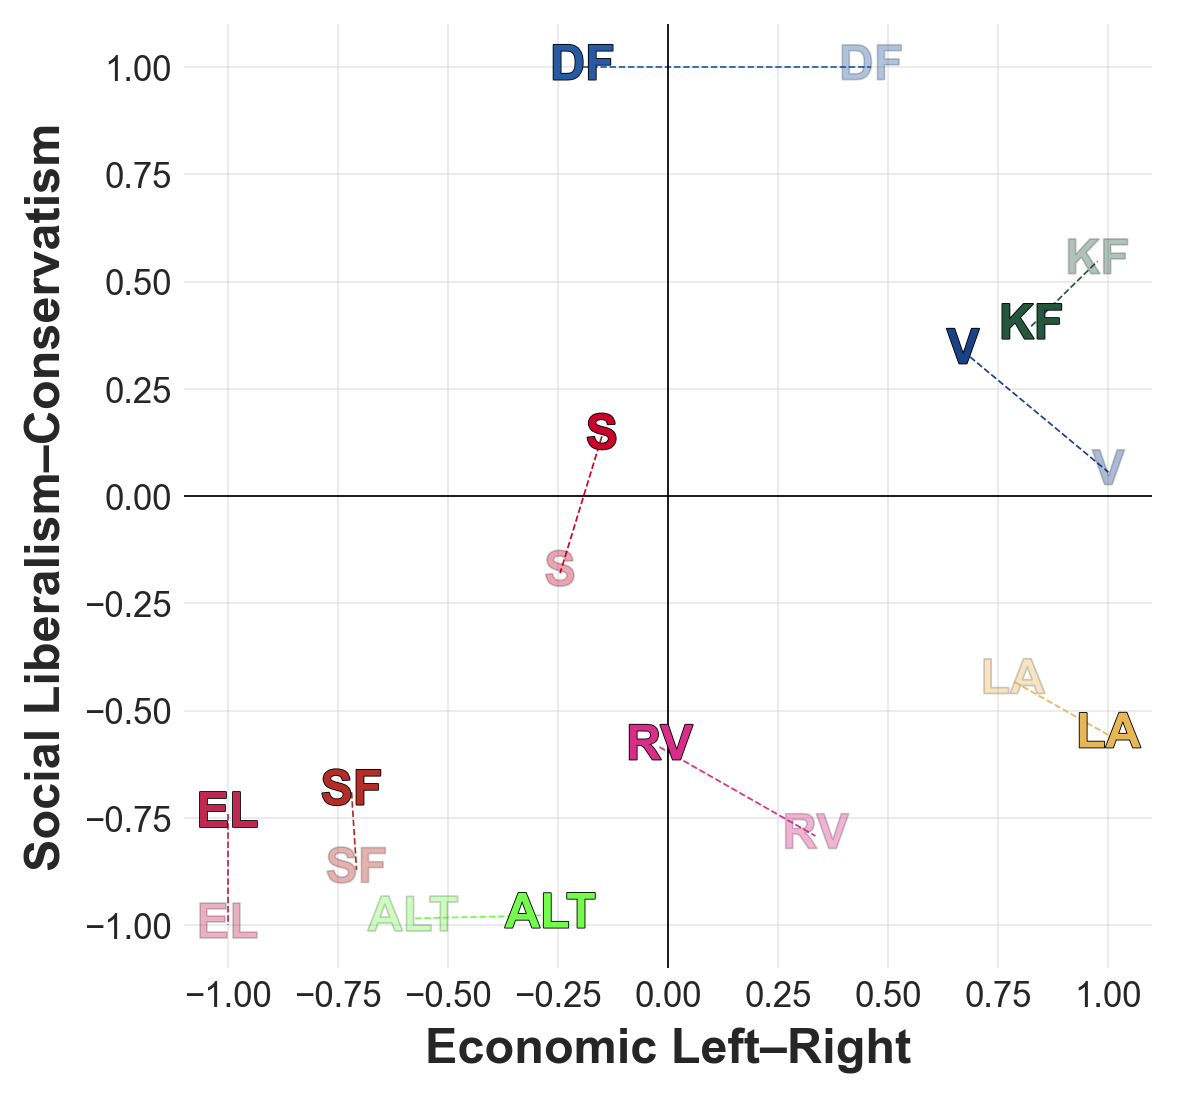

In [148]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_xlabel('Economic Left–Right', size = 14, weight = 'bold')
ax.set_ylabel('Social Liberalism–Conservatism', size = 14, weight = 'bold')

ax.scatter(df_plot['distrib'], -df_plot['value'], s=50, alpha=0.75, color='none')
ax.scatter(df_plot[distrib_comp], -df_plot[value_comp], s=50, alpha=0.75, color='none')

# add party labels
for i, txt in enumerate(df_plot['party']):
    ax.text(df_plot[distrib_comp][i], -df_plot[value_comp][i], txt, ha='center', va='center', fontsize=14, color=df_plot['color'][i], alpha=.2, weight='bold', path_effects=[pe.withStroke(linewidth=.5, foreground='black', alpha=.2)])

# add party labels
for i, txt in enumerate(df_plot['party']):
    ax.text(df_plot['distrib'][i], -df_plot['value'][i], txt, ha='center', va='center', fontsize=14, color=df_plot['color'][i], alpha=1, weight='bold', path_effects=[pe.withStroke(linewidth=.5, foreground='black', alpha=1)])

# add line segments between party positions
for i, txt in enumerate(df_plot['party']):
    ax.plot([df_plot['distrib'][i], df_plot[distrib_comp][i]], [-df_plot['value'][i], -df_plot[value_comp][i]], color=df_plot['color'][i], alpha=1, linewidth=.5, linestyle='--')

# add vline to plot
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.axhline(y=-0, color='black', linestyle='-', linewidth=0.5)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(color='lightgrey', linestyle='-', linewidth=0.5, alpha=0.5)

# Show the plot
plt.show()

(0.915736474757004, 0.0005261986066976326)


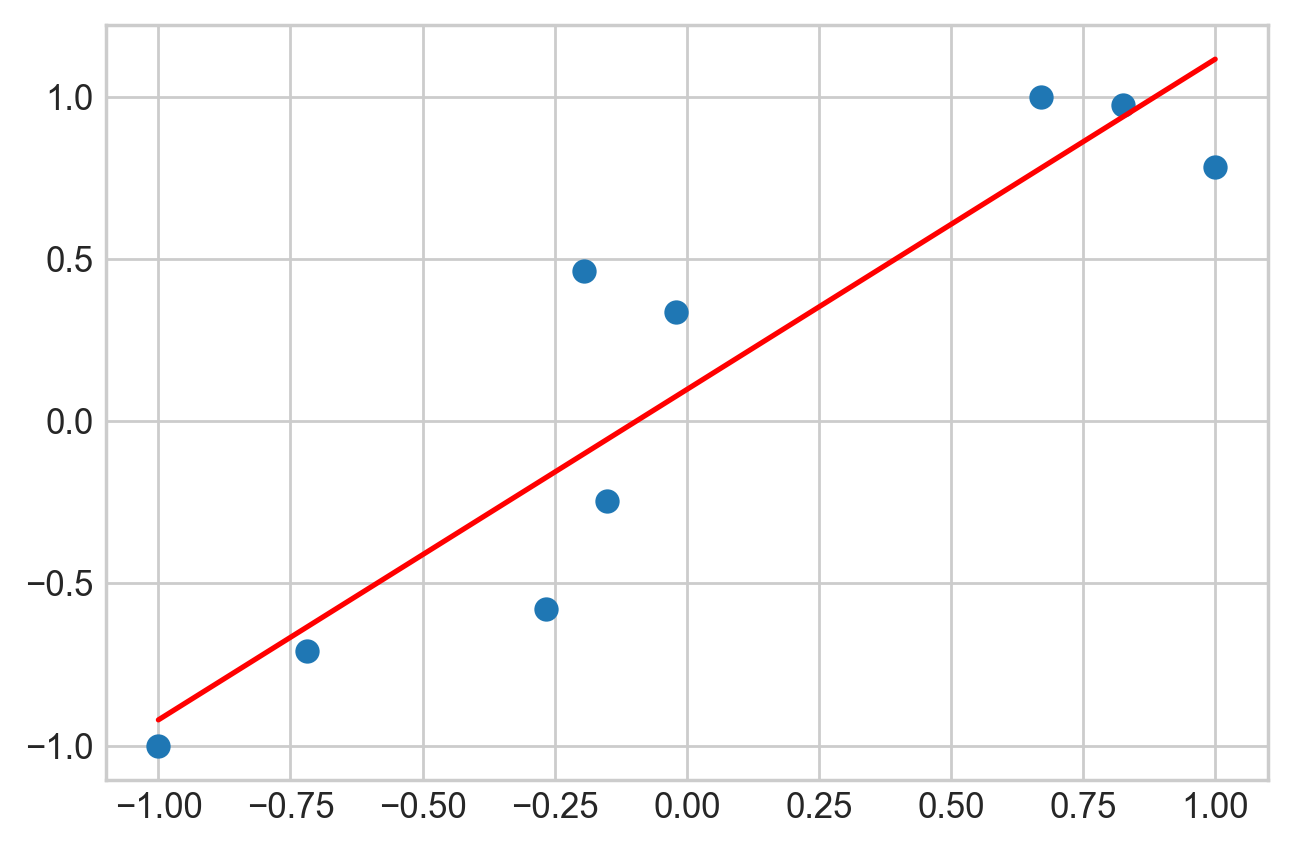

In [2069]:
# pearson r correlation between V4_scale and distrib
from scipy.stats import pearsonr
print(pearsonr(df_plot['distrib'], df_plot[distrib_comp]))

# scatter distrib and V4_scale against each other
plt.scatter(df_plot['distrib'], df_plot[distrib_comp])
# add regression line with plt
plt.plot(np.unique(df_plot['distrib']), np.poly1d(np.polyfit(df_plot['distrib'], df_plot[distrib_comp], 1))(np.unique(df_plot['distrib'])), color='red')

(0.9686012290850887, 1.751453650621301e-05)


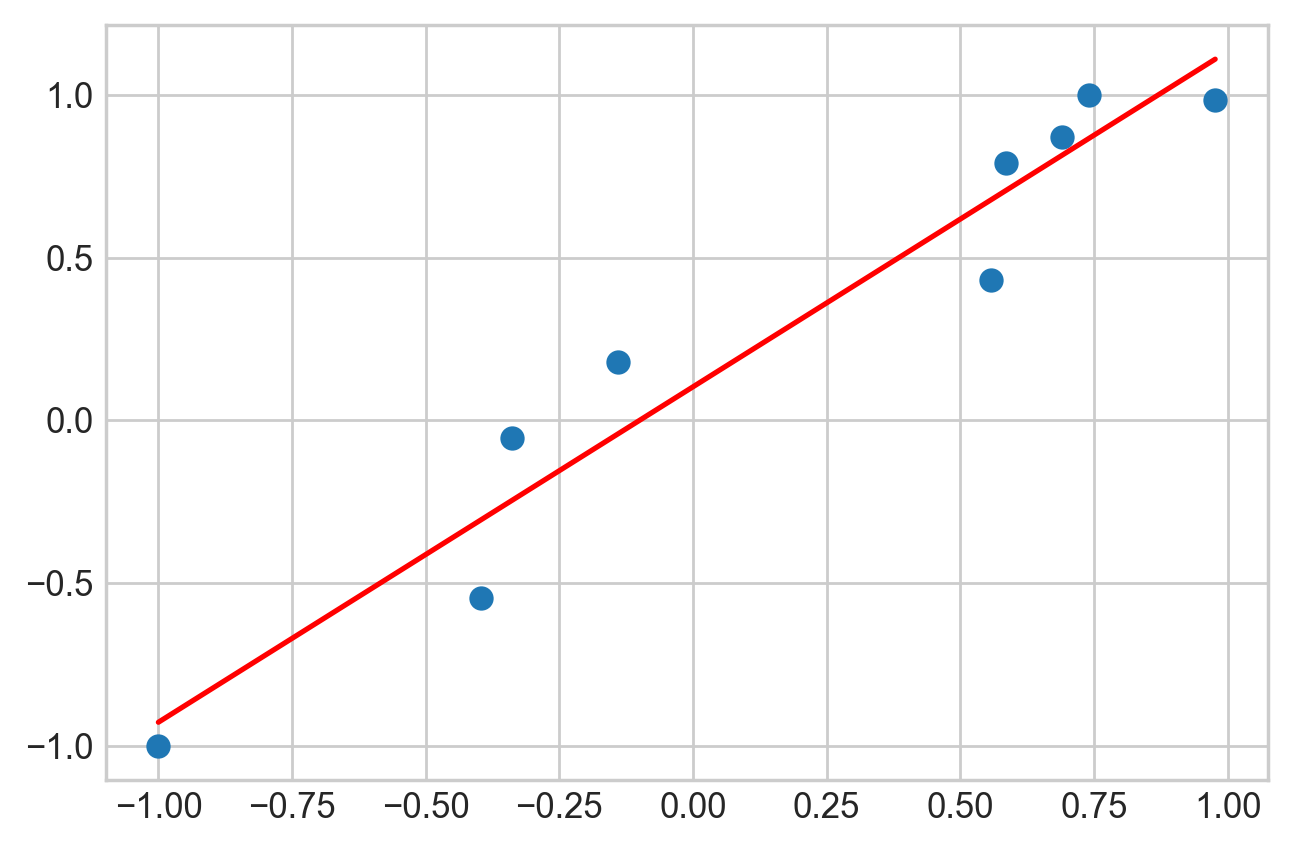

In [2070]:
print(pearsonr(df_plot['value'], df_plot[value_comp]))

# scatter value and V6_scale against each other
plt.scatter(df_plot['value'], df_plot[value_comp])
# add regression line with plt
plt.plot(np.unique(df_plot['value']), np.poly1d(np.polyfit(df_plot['value'], df_plot[value_comp], 1))(np.unique(df_plot['value'])), color='red')

In [2071]:
# ols regression between distrib and distrib_comp
import statsmodels.api as sm
X = df_plot['distrib']
y = df_plot[distrib_comp]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        PG_state_market   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     36.36
Date:                Thu, 18 May 2023   Prob (F-statistic):           0.000526
Time:                        11:00:24   Log-Likelihood:                -1.6099
No. Observations:                   9   AIC:                             7.220
Df Residuals:                       7   BIC:                             7.614
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0973      0.109      0.889      0.403      -0.161       0.356
distrib        1.0183      0.169      6.030      0.001       0.619       1.418
==============================================================================
Omnibus:                        0.572   Durbin-Watson:                   1.472
Prob(Omnibus):                  0.751   Jarque-Bera (JB):                0.454
Skew:                           0.435   Prob(JB):                        0.797
Kurtosis:                       2.326   Cond. No.                         1.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2072]:
X = df_plot['value']
y = df_plot[value_comp]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     PG_liberty_authority   R-squared:                       0.938
Model:                              OLS   Adj. R-squared:                  0.929
Method:                   Least Squares   F-statistic:                     106.2
Date:                  Thu, 18 May 2023   Prob (F-statistic):           1.75e-05
Time:                          11:00:25   Log-Likelihood:                 3.3010
No. Observations:                     9   AIC:                            -2.602
Df Residuals:                         7   BIC:                            -2.208
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1029      0.066      1.558      0.163      -0.053       0.259
value          1.0313      0.100     10.308      0.000       0.795       1.268
==============================================================================
Omnibus:                        1.829   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.401   Jarque-Bera (JB):                0.826
Skew:                          -0.253   Prob(JB):                        0.662
Kurtosis:                       1.605   Cond. No.                         1.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Candidate test validation (TV2)

In [2093]:
tv2_scales = pd.read_pickle('validation/tv2/tv2_scales.p')

In [2094]:
tv2_scales.head()

,name,partyLetter,distrib_scale,value_scale
1,Anne Honoré Østergaard,V,0.000,-0.500000
4,Marie Bjerre,V,0.000,-0.333333
7,Preben Bang Henriksen,V,-0.375,-0.166667
8,Torsten Schack Pedersen,V,0.125,-0.833333
10,Christian Langballe,DF,-0.250,-1.000000


In [2095]:
df_val = combined_hover.dropna()

In [2096]:
polvecs = pol2vec_model.document_vectors
polvecs.shape

(234, 300)

In [2097]:
# #project polvecs onto the subspace described by distrib_axis and value_axis
projection_matrix = np.stack((distrib_axis, value_axis), axis=1)
projected_matrix = polvecs.dot(projection_matrix)

embeddings = projected_matrix

normalised_emb = 2*(embeddings - np.min(embeddings, axis=0)) / np.ptp(embeddings, axis=0) - 1

# map dimension 1 and two of noarmalised_emb to df_plot
df_val['distrib'] = normalised_emb[:, 0]
df_val['value'] = normalised_emb[:, 1]


# df_val['distrib'] = rescale(polvecs.dot(distrib_axis))
# df_val['value'] = rescale(polvecs.dot(value_axis))

/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [2098]:
# merge tv2_val to df_val by name
df_val_merged = df_val.merge(tv2_scales, left_on='full_name', right_on='name', how='inner')

In [2099]:
df_val_merged.head()

,doc,party,snippet,color,full_name,rank,distrib,value,name,partyLetter,distrib_scale,value_scale
0,0.0,DF,jeg er lidt forvirret på et højere plan hvis j...,#265BA4,Alex Ahrendtsen,37.0,-0.302478,-0.232195,Alex Ahrendtsen,DF,-0.125,-0.666667
1,1.0,LA,statsministeren sagde i tirsdags at det simpel...,#E7B657,Alex Vanopslagh,13.0,0.443270,0.325007,Alex Vanopslagh,LA,-0.750,-0.333333
2,2.0,S,først og fremmest vil jeg sige tillykke med va...,#C8042C,Anders Kronborg,55.0,-0.619856,-0.155081,Anders Kronborg,S,0.375,-0.500000
3,4.0,RV,det var også godt der kom styr på vandet derop...,#D82E8A,Andreas Steenberg,15.0,0.426346,0.107965,Andreas Steenberg,RV,0.000,0.666667
4,5.0,S,er jo virkelig gode til flotte ord men jeg syn...,#C8042C,Ane Halsboe-Jørgensen,55.0,-0.391679,0.823083,Ane Halsboe-Jørgensen,S,0.625,-0.666667


In [2100]:
# rescale distrib_scale and value_scale to the range -1 to 1
df_val_merged['distrib_scale'] = rescale(df_val_merged['distrib_scale'])
df_val_merged['value_scale'] = rescale(df_val_merged['value_scale']) * -1

In [2101]:
corr = df_val_merged.corr()
corr.style.background_gradient(cmap='coolwarm')

,doc,rank,distrib,value,distrib_scale,value_scale
doc,1.000000,-0.187834,-0.057804,-0.040410,0.104640,-0.179436
rank,-0.187834,1.000000,0.087823,-0.167079,0.142741,0.450802
distrib,-0.057804,0.087823,1.000000,-0.103340,-0.299496,0.164593
value,-0.040410,-0.167079,-0.103340,1.000000,0.335916,-0.465490
distrib_scale,0.104640,0.142741,-0.299496,0.335916,1.000000,-0.581941
value_scale,-0.179436,0.450802,0.164593,-0.465490,-0.581941,1.000000


In [2102]:
df_val_merged.head()

,doc,party,snippet,color,full_name,rank,distrib,value,name,partyLetter,distrib_scale,value_scale
0,0.0,DF,jeg er lidt forvirret på et højere plan hvis j...,#265BA4,Alex Ahrendtsen,37.0,-0.302478,-0.232195,Alex Ahrendtsen,DF,-0.125,0.666667
1,1.0,LA,statsministeren sagde i tirsdags at det simpel...,#E7B657,Alex Vanopslagh,13.0,0.443270,0.325007,Alex Vanopslagh,LA,-0.750,0.333333
2,2.0,S,først og fremmest vil jeg sige tillykke med va...,#C8042C,Anders Kronborg,55.0,-0.619856,-0.155081,Anders Kronborg,S,0.375,0.500000
3,4.0,RV,det var også godt der kom styr på vandet derop...,#D82E8A,Andreas Steenberg,15.0,0.426346,0.107965,Andreas Steenberg,RV,0.000,-0.666667
4,5.0,S,er jo virkelig gode til flotte ord men jeg syn...,#C8042C,Ane Halsboe-Jørgensen,55.0,-0.391679,0.823083,Ane Halsboe-Jørgensen,S,0.625,0.666667


In [2103]:
# weighting scheme based on number of speeches
df_val_merged['weight'] = df_val_merged['full_name'].map(parl_data['full_name'].value_counts())
# normalise weight column
df_val_merged['weight'] = df_val_merged['weight'] / df_val_merged['weight'].sum()

# count of words in snippet
df_val_merged['weight'] = df_val_merged['snippet'].str.split().str.len()
# normalise weight column to between 0 and 1
df_val_merged['weight'] = df_val_merged['weight'] / df_val_merged['weight'].max()

In [2106]:
# Run WLS regression with distrib and distrib_scale
X = rescale(df_val_merged['distrib'])
y = -rescale(df_val_merged['distrib_scale'])
w = df_val_merged['weight']
X = sm.add_constant(X)
model = sm.WLS(y, X, weights=w).fit()
predictions = model.predict(X)
print(model.summary())

                            WLS Regression Results                            
Dep. Variable:          distrib_scale   R-squared:                       0.138
Model:                            WLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     22.53
Date:                Thu, 18 May 2023   Prob (F-statistic):           5.03e-06
Time:                        11:46:56   Log-Likelihood:                -131.97
No. Observations:                 143   AIC:                             267.9
Df Residuals:                     141   BIC:                             273.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1799      0.044     -4.055      0.0

In [2109]:
# Run WLS regression with distrib and distrib_scale
X = rescale(df_val_merged['value'])
y = -rescale(df_val_merged['value_scale']) # MAKE SURE WE RESCALE AFTER MERGING TO MAKE INCLUDED MPS COMPARABLE!
w = df_val_merged['weight']
X = sm.add_constant(X)
model = sm.WLS(y, X, weights=w).fit()
predictions = model.predict(X)
print(model.summary())

                            WLS Regression Results                            
Dep. Variable:            value_scale   R-squared:                       0.270
Model:                            WLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     52.23
Date:                Thu, 18 May 2023   Prob (F-statistic):           2.85e-11
Time:                        11:47:20   Log-Likelihood:                -141.18
No. Observations:                 143   AIC:                             286.4
Df Residuals:                     141   BIC:                             292.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1651      0.047     -3.496      0.0

In [1834]:
tv2_val

,doc,party,snippet,color,full_name,rank
0,0.0,DF,jeg er lidt forvirret på et højere plan hvis j...,#265BA4,Alex Ahrendtsen,37.0
1,1.0,LA,statsministeren sagde i tirsdags at det simpel...,#E7B657,Alex Vanopslagh,13.0
2,2.0,S,først og fremmest vil jeg sige tillykke med va...,#C8042C,Anders Kronborg,55.0
3,3.0,LA,først og fremmest skal man vel ønske færøerne ...,#E7B657,Anders Samuelsen,13.0
4,4.0,RV,det var også godt der kom styr på vandet derop...,#D82E8A,Andreas Steenberg,15.0
...,...,...,...,...,...,...
229,229.0,ALT,jeg vil gerne spørge ordføreren om han overhov...,#75FB4C,Ulla Sandbæk,11.0
230,230.0,V,ungdomsuddannelse for unge med særlige behov k...,#1A4289,Ulla Tørnæs,47.0
231,231.0,LA,jeg har forstået at der kommer mange emner ind...,#E7B657,Villum Christensen,13.0
232,232.0,S,nu insisterer ordføreren meget på at man komme...,#C8042C,Yildiz Akdogan,55.0


In [1946]:
pearsonr(df_val_merged['distrib'], -df_val_merged['distrib_scale'])

(0.3061394044076521, 0.0002004482289143193)

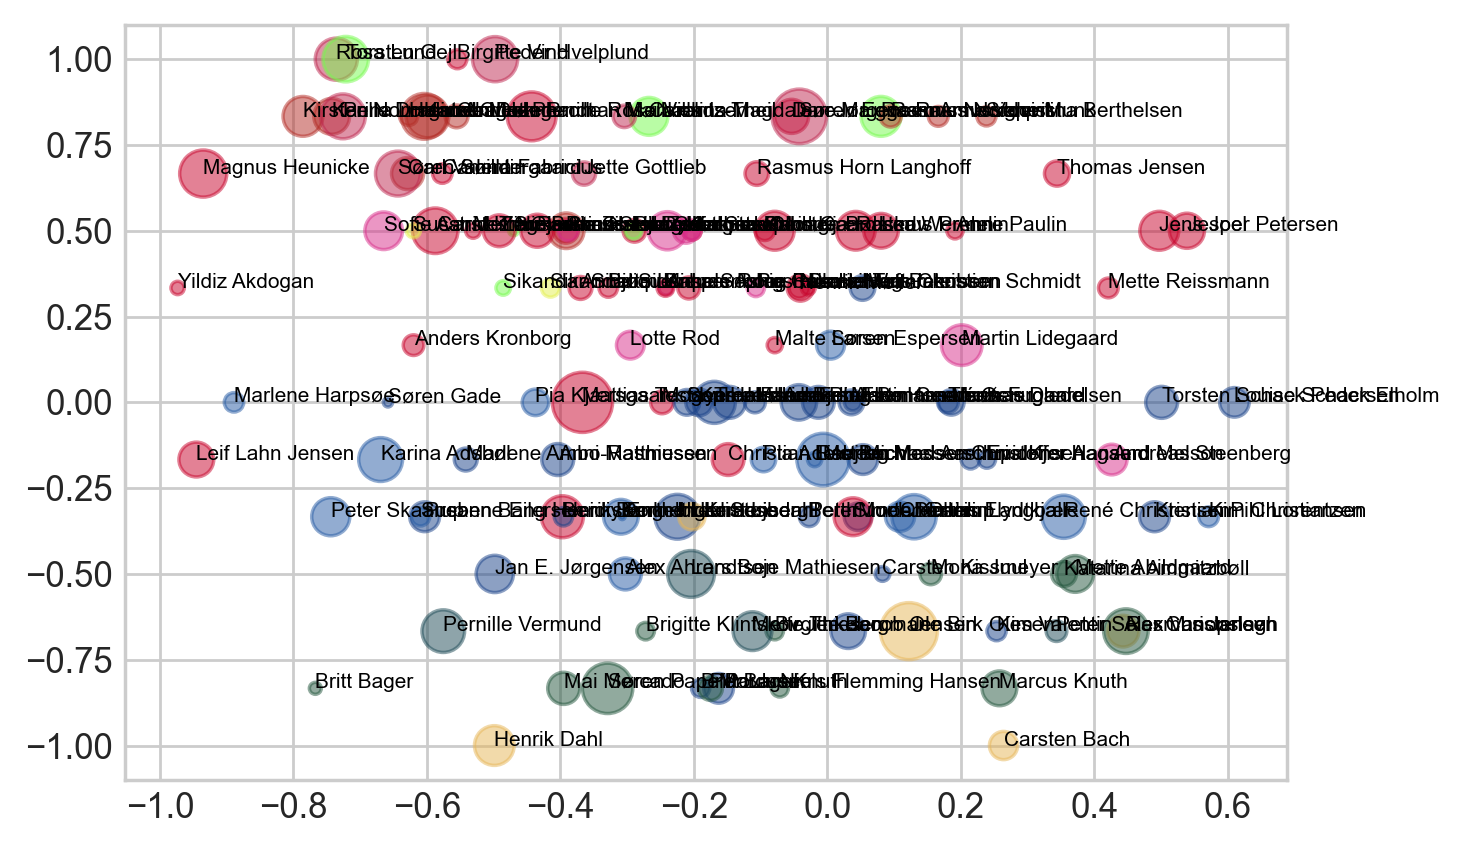

In [1777]:
# scatterplot of distrib_scale and value_scale
plt.scatter(df_val_merged['distrib'], df_val_merged['distrib_scale'], c = df_val_merged['color'], alpha=0.5, s=df_val_merged['weight']*300)
# plot full_names if weight is above 0.05
for i, txt in enumerate(df_val_merged['full_name']):
    if df_val_merged['weight'][i] > 0.0072:
        plt.annotate(txt, (df_val_merged['distrib'][i], df_val_merged['distrib_scale'][i]), fontsize=6, color='black')

plt.show()

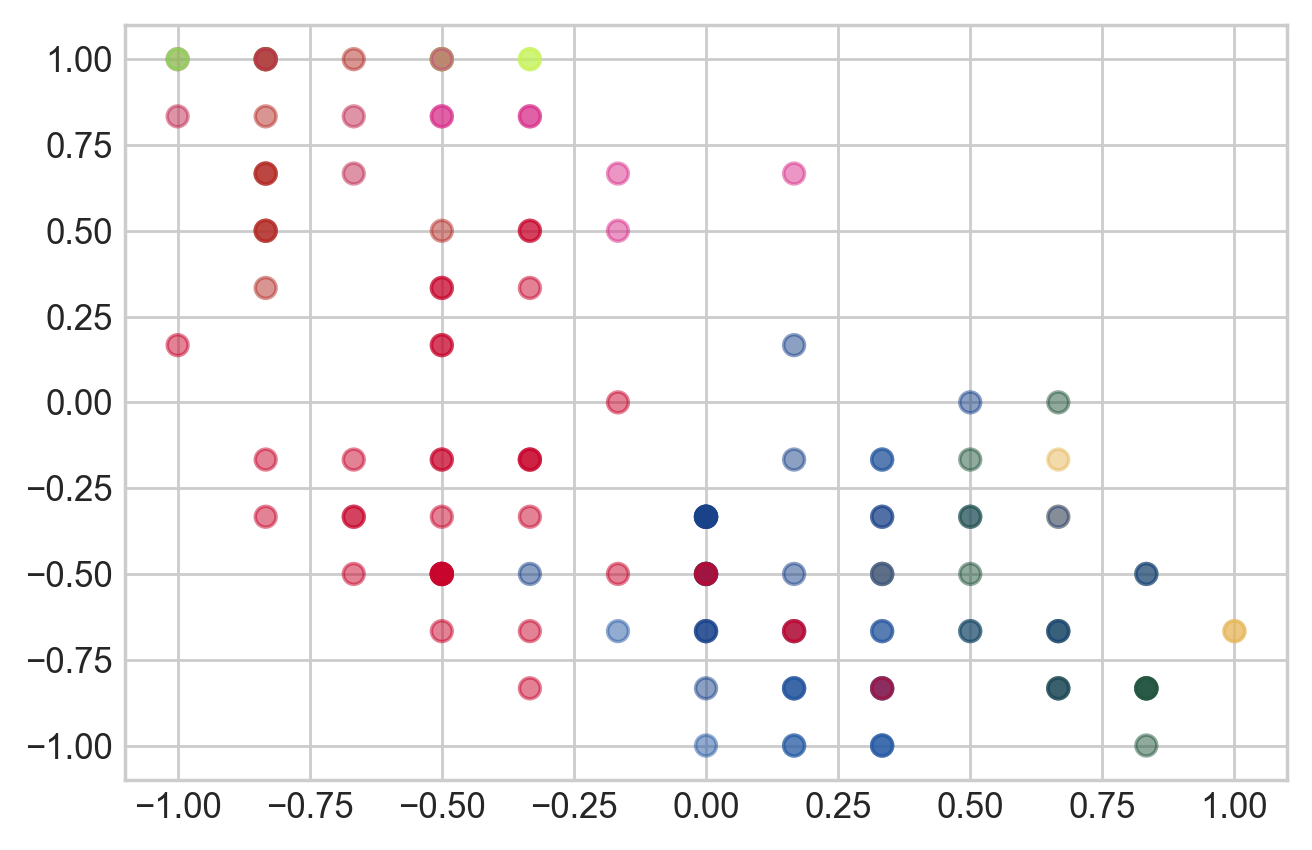

In [1778]:
# scatterplot of distrib_scale and value_scale
plt.scatter(-df_val_merged['distrib_scale'], -df_val_merged['value_scale'], c = df_val_merged['color'], alpha=0.5)